In [59]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
from sklearn import linear_model

In [2]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [3]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [4]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [5]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [6]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [7]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [8]:
len(listOfBs)

259

In [87]:
df_mess_train['did'].unique().shape

(113,)

In [67]:
# Feature Matrix construction 
def feat_mat_const(df_mess_train, listOfBs):
    df = df_mess_train
    df['active'] = 1
    return df.pivot_table(index='messid', 
                                    values=['active', 'nseq','rssi', 'bs_lat', 'bs_lng'], 
                                    columns=['bsid'],
                                    fill_value=0)

In [46]:
# ground truth construction
def ground_truth_const(df_mess_train, pos_train):
    
    df = pd.concat([df_mess_train['messid'], pos_train], axis=1)
    df2 = df.groupby('messid').mean()
    print(df2.columns)
    return df2['lat'], df2['lng']

In [68]:
df_feat = feat_mat_const(df_mess_train, listOfBs)
df_feat.head()

active                                            \
bsid                      879   911   921   944   980   1012  1086  1092    
messid                                                                      
573bf1d9864fce1a9af8c5c9      0     0     0     0     0     0     0     0   
573bf3533e952e19126b256a      0     0     0     0     0     0     0     0   
573c0cd0f0fe6e735a699b93      0     0     0     0     0     0     0     0   
573c1272f0fe6e735a6cb8bd      0     0     0     0     0     0     0     0   
573c8ea8864fce1a9a5fbf7a      0     0     0     0     0     0     1     0   

                                      ...  rssi                           \
bsid                     1120  1148   ... 8747  9784   9899  10134 10148   
messid                                ...                                  
573bf1d9864fce1a9af8c5c9     0     0  ...   0.0     0    0.0     0     0   
573bf3533e952e19126b256a     0     0  ...   0.0     0    0.0     0     0   
573c0cd0f0fe6e735a699b93     0     0  ...   0.0     0    0.0     0     0   
573c1272f0fe6e735a6cb8bd     0     0  ...   0.0     0    0.0     0     0   
573c8ea8864fce1a9a5fbf7a     0     0  ...   0.0     0 -129.0     0     0   

                                                        
bsid                     10151 10162 10999 11007 11951  
messid                                                  
573bf1d9864fce1a9af8c5c9   0.0   0.0     0   0.0     0  
573bf3533e952e19126b256a   0.0   0.0     0   0.0     0  
573c0cd0f0fe6e735a699b93   0.0   0.0     0   0.0     0  
573c1272f0fe6e735a6cb8bd   0.0   0.0     0   0.0     0  
573c8ea8864fce1a9a5fbf7a   0.0   0.0     0   0.0     0  

[5 rows x 1255 columns]

In [70]:
#df_feat.reset_index(1).head()

In [71]:
df_feat.shape

(6068, 1255)

In [72]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

Index(['lat', 'lng'], dtype='object')


(6068,)

In [73]:
# Validation

In [74]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);
    reg = linear_model.LinearRegression()

    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 
    
    return y_pred_lat, y_pred_lng

In [75]:
# Make regressor and prediction using the train set

In [76]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

In [77]:
# Cross validation

In [78]:
# Evaluate result

In [79]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [80]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [81]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

/Users/antoinehue/Library/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  


In [82]:
# Plot error distribution

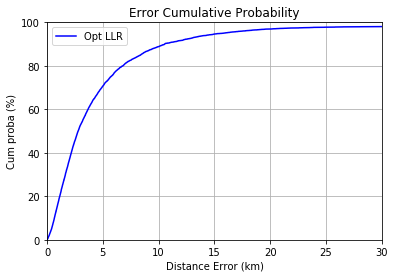

In [83]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])
plt.grid(); 

In [84]:
# Error criterion

np.percentile(err_vec, 80)

6789.1197580863045

In [85]:
# Construct test prediction